In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats
import scipy.optimize as spo
from scipy.optimize import minimize
from helpers_similarity import *
from helpers_optimization import *

In [38]:
# standard deviation of spherical Gaussian distribution
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2#[0, 0.2, 0.4, 0.6, 0.8, 1] 

D = 2 #dimension
N = 10 #nbr of users = 10
M = 10 #nbr of movies : M=5*alpha M = 10, 30, 100, 300, 1000
alpha = 1 
alpha_vals = [1, 3, 10, 30]#, 30] #[1,5,10,50,100]
k_best = 10 # 
nb_iter = 100 #1000

optimize the objective function by minimizing it w.r.t U and V respectively 

In [39]:
def optimization_fn(alpha,N_val):
    M_cols = M*alpha
    U, V, R = generate_U_V_R(mu, sigma_u, sigma_v, sigma, alpha, D, N_val, M)

    U0 = np.random.normal(mu, sigma_u, D*N_val) 
    V0 = np.random.normal(mu, sigma_v, D*M_cols) #np.random.randn(D*M_cols) random guess for V0
    U_res = minimize(objective_function_U, U0, args=(R, V, sigma_u, sigma_v, sigma, D, N_val))
    V_res = minimize(objective_function_V, V0, args=(R, U, sigma_u, sigma_v, sigma, D, M_cols))

    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((D, N_val))
    else :
        print('No minimum found for U')
        U_result = np.zeros((D, N_val))
    diff_norm_U = frob(U, U_result, N_val)
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((D, M_cols))
    else :
        print('No minimum found for V')
        V_result = np.zeros((D, M_cols))
    diff_norm_V = frob(V, V_result, M_cols)
    #diff_norm = procrustes_norm(V, V_result, M)
    return diff_norm_U, diff_norm_V


compute average Difference (in Frobenius/ Procrustes norm) of U, U_result and V, V_result for different values of M

In [40]:
def norm_results(alpha,N_val):
        avg_U = 0
        avg_V = 0
        for i in range(nb_iter):
            diff_U, diff_V = optimization_fn(alpha,N_val)
            avg_U += diff_U
            avg_V += diff_V
        avg_U = avg_U/nb_iter
        avg_V = avg_V/nb_iter
        return avg_U, avg_V

In [45]:
N_vals = [10, 30, 60, 100]#, 300, 1000]
data = []
for i in range(len(N_vals)):
    for j in range(len(alpha_vals)):
        avg_U, avg_V = norm_results(alpha_vals[j],N_vals[i])
        row= [N_vals[j], M*alpha_vals[i], avg_U, avg_V]
        data.append(row)       


KeyboardInterrupt: 

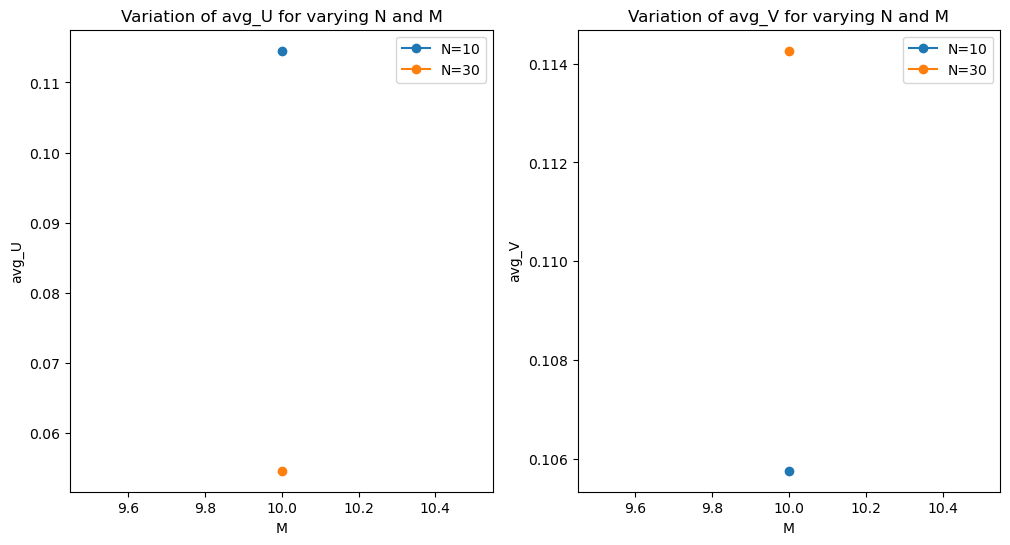

In [49]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
    ax2.plot(df_m['M'], df_m['avg_V'], marker='o', label=f'N={n}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('M')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

In [43]:
fig.savefig('avg_U_V.png')
